In [ ]:
%%capture
!pip install evaluate scikit-learn

# LLM for MCQs

### Load Data

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import random
import itertools
from transformers import AutoTokenizer, DataCollatorForMultipleChoice, AutoModelForMultipleChoice, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import torch
import evaluate
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import math
from google.colab import drive
from matplotlib.ticker import PercentFormatter

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ds = load_dataset("allenai/swag")

### EDA

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20005
    })
})

In [ ]:
ds['train'][0]

{'video-id': 'anetv_jkn6uvmqwh4',
 'fold-ind': '3416',
 'startphrase': 'Members of the procession walk down the street holding small horn brass instruments. A drum line',
 'sent1': 'Members of the procession walk down the street holding small horn brass instruments.',
 'sent2': 'A drum line',
 'gold-source': 'gold',
 'ending0': 'passes by walking down the street playing their instruments.',
 'ending1': 'has heard approaching them.',
 'ending2': "arrives and they're outside dancing and asleep.",
 'ending3': 'turns the lead singer watches the performance.',
 'label': 0}

In [ ]:
train = ds["train"]
val = ds["validation"]
test = ds["test"]
train.features

{'video-id': Value('string'),
 'fold-ind': Value('string'),
 'startphrase': Value('string'),
 'sent1': Value('string'),
 'sent2': Value('string'),
 'gold-source': Value('string'),
 'ending0': Value('string'),
 'ending1': Value('string'),
 'ending2': Value('string'),
 'ending3': Value('string'),
 'label': ClassLabel(names=['0', '1', '2', '3'])}

In [ ]:
print({k: v.num_rows for k, v in ds.items()})

{'train': 73546, 'validation': 20006, 'test': 20005}


In [ ]:
label_counts = Counter(train["label"])
print("Label counts (train):", label_counts)

Label counts (train): Counter({3: 18458, 0: 18414, 2: 18340, 1: 18334})


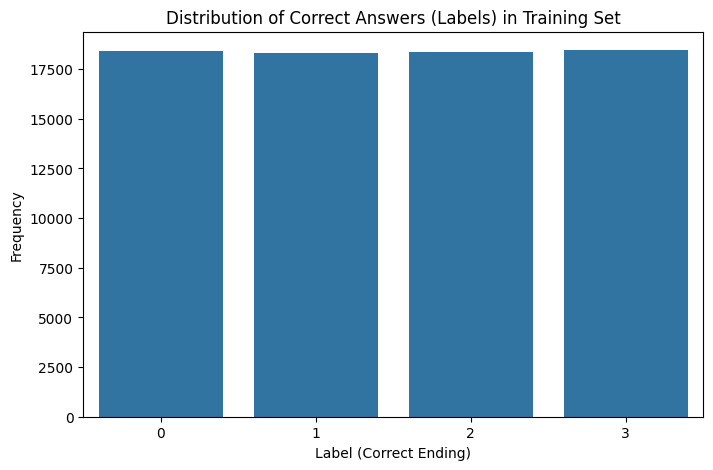

In [ ]:
labels = pd.Series(ds['train']['label'])
plt.figure(figsize=(8, 5))
sns.countplot(x=labels)
plt.title('Distribution of Correct Answers (Labels) in Training Set')
plt.xlabel('Label (Correct Ending)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def lens(ex):
    main_script = (ex["sent1"] + " " + ex["sent2"]).strip()
    return {
        "main_script_len": len(main_script.split()),
        "e0_len": len(ex["ending0"].split()),
        "e1_len": len(ex["ending1"].split()),
        "e2_len": len(ex["ending2"].split()),
        "e3_len": len(ex["ending3"].split()),
    }

lengths = pd.DataFrame([lens(train[i]) for i in range(min(5000, len(train)))])
print(lengths.describe().T[["mean","std","min","max"]])

                    mean       std  min   max
main_script_len  13.9330  6.744598  4.0  87.0
e0_len            8.6208  4.022368  2.0  25.0
e1_len            8.6034  3.971456  1.0  25.0
e2_len            8.6018  3.987683  2.0  25.0
e3_len            8.5962  4.030831  1.0  25.0


In [ ]:
cols = ["sent1","sent2","startphrase","ending0","ending1","ending2","ending3"]
empty_rate = {
    c: float(np.mean([not bool((x or "").strip()) for x in train[c]]))
    for c in cols
}
print("Empty string rate per column:", empty_rate)

Empty string rate per column: {'sent1': 0.0, 'sent2': 0.0, 'startphrase': 0.0, 'ending0': 0.0, 'ending1': 0.0, 'ending2': 0.0, 'ending3': 0.0}


### Preprocess

In [ ]:
model_id = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
num_choices = 4
ending_keys = [f"ending{i}" for i in range(num_choices)]
max_length=128
def preprocess(examples):
    contexts, options = [], []
    for s1, s2, *ends in zip(examples["sent1"], examples["sent2"], *[examples[k] for k in ending_keys]):
        main_script = f"{s1} {s2}".strip()
        for e in ends:
            contexts.append(main_script)
            options.append(e)

    tokenized = tokenizer(
        contexts,
        options,
        truncation=True,
        max_length=max_length,
        padding=False,
    )

    def chunk(lst, n):
        return [lst[i:i+n] for i in range(0, len(lst), n)]
    features = {k: chunk(v, num_choices) for k, v in tokenized.items()}
    features["labels"] = examples["label"]
    return features

In [ ]:

encoded_ds = ds.map(
    preprocess,
    batched=True,
    remove_columns=ds["train"].column_names
)
print(encoded_ds)

Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20005
    })
})


In [ ]:
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding="longest")

### Load Model

In [ ]:
model = AutoModelForMultipleChoice.from_pretrained(model_id)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Test the Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
idx = 5
raw = ds["validation"][idx]
batch = data_collator([encoded_ds["validation"][idx]])
batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}

with torch.no_grad():
    outputs = model(**batch)
logits = outputs.logits.squeeze(0).cpu().numpy()
probs = (np.exp(logits) / np.exp(logits).sum())
pred = int(logits.argmax())
gold = int(ds["validation"][idx]["label"])
print("\n--- Single Example Analysis ---")
print("Context:", raw["sent1"], raw["sent2"])
for i in range(4):
    print(f"  ending{i}: {raw[f'ending{i}']}  |  probability = {probs[i]:.3f}")
print(f"Predicted: {pred} | Gold: {gold} | Correct? {pred == gold}")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



--- Single Example Analysis ---
Context: The man holds a pointy tool that uses to fix the handle of the bike. The man
  ending0: takes out the cover of the handlebar and rise with the tool and spray liquid inside, then press the handle with his hand.  |  probability = 0.179
  ending1: continues to take a bite of the bakes.  |  probability = 0.325
  ending2: laughs and does little more flips.  |  probability = 0.286
  ending3: looks down at the young man and stands next to a man dressed as a man stands on a sidewalk.  |  probability = 0.210
Predicted: 1 | Gold: 0 | Correct? False


In [ ]:
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def _softmax(x, axis=-1):
    x = x - x.max(axis=axis, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=axis, keepdims=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    probs = _softmax(logits, axis=-1)

    out = {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }
    return out

In [ ]:
baseline_args = TrainingArguments(
    output_dir = "swag_baseline",
    per_device_eval_batch_size = 32,
    dataloader_drop_last = False,
    fp16 = True,
    report_to = "none"
)

baseline_trainer = Trainer(
    model = model,
    args = baseline_args,
    eval_dataset = encoded_ds["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

/tmp/ipython-input-2877027937.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


In [ ]:
res_baseline = baseline_trainer.evaluate()

In [ ]:
print("\n--- Baseline Metrics ---")
print(f"Accuracy: {res_baseline['eval_accuracy']:.3f}")
print(f"F1-Macro: {res_baseline['eval_f1_macro']:.3f}")


--- Baseline Metrics ---
Accuracy: 0.119
F1-Macro: 0.119


### In-Context Learning (ICL)

In [ ]:
def make_preprocess_fn(tokenizer, max_length=128, prefix=""):
    num_choices = 4
    ending_keys = [f"ending{i}" for i in range(num_choices)]
    prefix = prefix.strip()
    prefix_ = (prefix + "\n\n") if prefix else ""

    def _preprocess(examples):
        contexts, options = [], []
        for s1, s2, *ends in zip(examples["sent1"], examples["sent2"], *[examples[k] for k in ending_keys]):
            ctx = f"{prefix_}Context: {s1} {s2}".strip()
            for e in ends:
                contexts.append(ctx)
                options.append(e)
        tokenized = tokenizer(contexts, options, truncation=True, max_length=max_length, padding=False  )
        def chunk(lst, n): return [lst[i:i+n] for i in range(0, len(lst), n)]
        features = {k: chunk(v, num_choices) for k, v in tokenized.items()}
        features["labels"] = examples["label"]
        return features
    return _preprocess

In [ ]:
# ICL Few-shot
LETTER = {0:"A", 1:"B", 2:"C", 3:"D"}
def format_demo(ex):
    ctx = f"Context: {ex['sent1']} {ex['sent2']}"
    opts = "\n".join([
        f"A) {ex['ending0']}",
        f"B) {ex['ending1']}",
        f"C) {ex['ending2']}",
        f"D) {ex['ending3']}",
    ])
    ans = LETTER[int(ex["label"])]
    return f"{ctx}\n{opts}\nAnswer: {ans}"

def build_fewshot_prefix(train_split, k=4, seed=42):
    rng = random.Random(seed)
    idxs = rng.sample(range(len(train_split)), k)
    demos = [format_demo(train_split[i]) for i in idxs]
    instr = "Task: Choose the most plausible continuation (A–D). Here are solved examples:\n\n"
    return instr + "\n\n".join(demos) + "\n\nNow solve the next one."

fewshot_prefix = build_fewshot_prefix(ds["train"], k=4, seed=42)
fewshot_prep  = make_preprocess_fn(tokenizer, max_length=256, prefix=fewshot_prefix)

encoded_val_fewshot = ds["validation"].map(fewshot_prep, batched=True, remove_columns=ds["validation"].column_names)

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

In [ ]:
# ICL Zero-shot CoT
cot_prefix = (
    "Task: Choose the most plausible continuation (A–D) for the context. "
    "Let's think step by step."
)
cot_prep = make_preprocess_fn(tokenizer, max_length=192, prefix=cot_prefix)
encoded_val_cot = ds["validation"].map(cot_prep, batched=True, remove_columns=ds["validation"].column_names)

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

In [ ]:
icl_args = TrainingArguments(
    output_dir="swag_icls",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    fp16=True,
    report_to="none",
)
fewshot_trainer = Trainer(
    model=model,
    args=icl_args,
    eval_dataset=encoded_val_fewshot,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-4042863863.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fewshot_trainer = Trainer(


In [ ]:
res_fewshot = fewshot_trainer.evaluate(encoded_val_fewshot)

In [ ]:
cot_trainer = Trainer(
    model=model,
    args=icl_args,
    eval_dataset=encoded_val_cot,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1773764595.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  cot_trainer = Trainer(


In [ ]:
res_cot = cot_trainer.evaluate(encoded_val_cot)

In [ ]:
rows = [
    ("Few-shot ICL (k=4)", res_fewshot["eval_accuracy"]),
    ("Zero-shot CoT",      res_cot["eval_accuracy"]),
]
print("\nModel\t\t\t\tAccuracy")
for name, accv in rows:
    print(f"{name:24s}\t{accv:.4f}")


Model				Accuracy
Few-shot ICL (k=4)      	0.2642
Zero-shot CoT           	0.1364


### Fine-tuning

In [ ]:
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query","value", "key"],
    bias="none"
)

In [ ]:
lora_model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")
lora_model = get_peft_model(lora_model, lora_cfg)
lora_model.print_trainable_parameters()

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 443,137 || all params: 109,926,146 || trainable%: 0.4031


In [ ]:
num_epochs = 2
per_device_train_bs = 8
per_device_eval_bs  = 32
grad_accum = 4
lr = 2e-5

In [ ]:
train_args_peft = TrainingArguments(
    output_dir="swag_lora_finetune",
    learning_rate=lr,
    per_device_train_batch_size=per_device_train_bs,
    per_device_eval_batch_size=per_device_eval_bs,
    gradient_accumulation_steps=grad_accum,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    report_to="none",
    logging_steps=50
)

peft_trainer = Trainer(
    model=lora_model,
    args=train_args_peft,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3985074118.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  peft_trainer = Trainer(


In [ ]:
peft_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.887300,0.768593,0.702739,0.702745
2,0.904300,0.739267,0.713136,0.713145


TrainOutput(global_step=4598, training_loss=0.972850505867021, metrics={'train_runtime': 1442.739, 'train_samples_per_second': 101.953, 'train_steps_per_second': 3.187, 'total_flos': 1.49257162554552e+16, 'train_loss': 0.972850505867021, 'epoch': 2.0})

### Save Model

In [ ]:
drive_ckpt_dir = "/content/drive/MyDrive/checkpoints/bert_swag_peft"
train_args_peft.output_dir = drive_ckpt_dir
peft_trainer.args = train_args_peft
peft_trainer.save_model(drive_ckpt_dir)
tokenizer.save_pretrained(drive_ckpt_dir)
print("Everything stored in Drive: ", drive_ckpt_dir)

Everything stored in Drive:  /content/drive/MyDrive/checkpoints/bert_swag_peft


In [ ]:
src  = "/content/swag_lora_finetune"
dest = "/content/drive/MyDrive/checkpoints/bert_swag_peft"

!mkdir -p "$dest"
!cp -r "$src"/* "$dest"

print("Copied to Drive: ", dest)

Copied to Drive:  /content/drive/MyDrive/checkpoints/bert_swag_peft


### Load Model for Further Training

In [ ]:
mod_address = "/content/drive/MyDrive/checkpoints/bert_swag_peft"
loaded_tokenizer = AutoTokenizer.from_pretrained(mod_address, use_fast=True)
base = AutoModelForMultipleChoice.from_pretrained(model_id)
loaded_model = PeftModel.from_pretrained(base, mod_address)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loaded_model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForMultipleChoice(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linea

In [ ]:
train_args_peft = TrainingArguments(
    output_dir="loaded_swag_lora_finetune",
    learning_rate=lr,
    per_device_train_batch_size=per_device_train_bs,
    per_device_eval_batch_size=per_device_eval_bs,
    gradient_accumulation_steps=grad_accum,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    report_to="none",
    logging_steps=50,
)

loaded_trainer = Trainer(
    model=loaded_model,
    args=train_args_peft,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    data_collator=data_collator,
    tokenizer=loaded_tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1975294794.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  loaded_trainer = Trainer(


In [ ]:
loaded_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.856000,0.738428,0.714036,0.714043
2,0.902500,0.738045,0.714536,0.714543


TrainOutput(global_step=4598, training_loss=0.8871397339504353, metrics={'train_runtime': 949.9103, 'train_samples_per_second': 154.848, 'train_steps_per_second': 4.84, 'total_flos': 1.49257162554552e+16, 'train_loss': 0.8871397339504353, 'epoch': 2.0})

### Evaluate

In [ ]:
post_metrics = loaded_trainer.evaluate(encoded_ds["validation"])

In [ ]:
post_acc = post_metrics["eval_accuracy"]
post_loss = post_metrics["eval_loss"]
post_ppl = math.exp(post_loss)
print("\n=== Post-fine-tune (LoRA) Metrics ===")
print(f"Accuracy: {post_acc:.4f}")
print(f"Loss: {post_loss:.4f}")
print(f"Perplexity:  {post_ppl:.4f}")


=== Post-fine-tune (LoRA) Metrics ===
Accuracy: 0.7145
Loss: 0.7380
Perplexity:  2.0918


In [ ]:
pred_out = loaded_trainer.predict(encoded_ds["validation"])

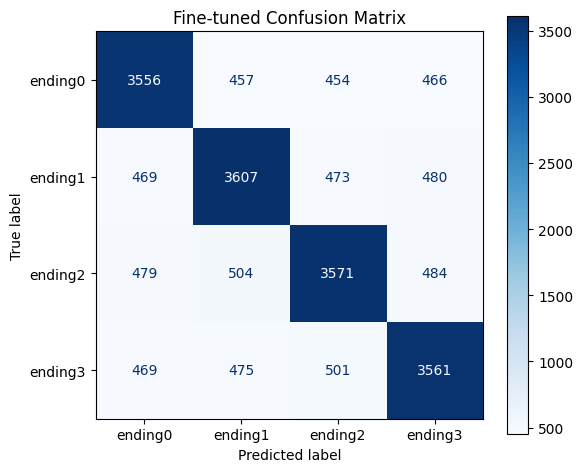

In [ ]:
logits = pred_out.predictions
labels = pred_out.label_ids
preds  = logits.argmax(axis=-1)
class_ids = [0, 1, 2, 3]
class_names = ["ending0", "ending1", "ending2", "ending3"]
cm = confusion_matrix(labels, preds, labels=class_ids)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, ax=ax, cmap="Blues")
ax.set_title("Fine-tuned Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(labels, preds, labels=[0,1,2,3], digits=3))


Classification Report:
              precision    recall  f1-score   support

           0      0.715     0.721     0.718      4933
           1      0.715     0.717     0.716      5029
           2      0.714     0.709     0.712      5038
           3      0.713     0.711     0.712      5006

    accuracy                          0.715     20006
   macro avg      0.715     0.715     0.715     20006
weighted avg      0.715     0.715     0.715     20006



In [ ]:
rows = [
    ("Baseline", res_baseline["eval_accuracy"]),
    ("Few-shot ICL", res_fewshot["eval_accuracy"]),
    ("Zero-shot CoT", res_cot["eval_accuracy"]),
    ("Fine-tuned", post_acc),
]
print("Validation Accuracy")
print("Model\t\t\t\t\tAccuracy")
for name, accv in rows:
    print(f"{name:32s}\t{accv:.4f}")

Validation Accuracy
Model					Accuracy
Baseline                        	0.1190
Few-shot ICL                    	0.2642
Zero-shot CoT                   	0.1364
Fine-tuned                      	0.7145


### In-Context Learning with the Fine-Tuned Model

In [ ]:
res_finetuned_fewshot = loaded_trainer.evaluate(encoded_val_fewshot)

In [ ]:
preds_finetuned_fewshot = loaded_trainer.predict(encoded_val_fewshot)

In [ ]:
post_acc = res_finetuned_fewshot["eval_accuracy"]
post_loss = res_finetuned_fewshot["eval_loss"]
post_ppl = math.exp(post_loss)
print("\n=== Fine-tune + CoT Metrics ===")
print(f"Accuracy: {post_acc:.4f}")
print(f"Loss: {post_loss:.4f}")
print(f"Perplexity:  {post_ppl:.4f}")


=== Fine-tune + CoT Metrics ===
Accuracy: 0.3819
Loss: 1.3355
Perplexity:  3.8019


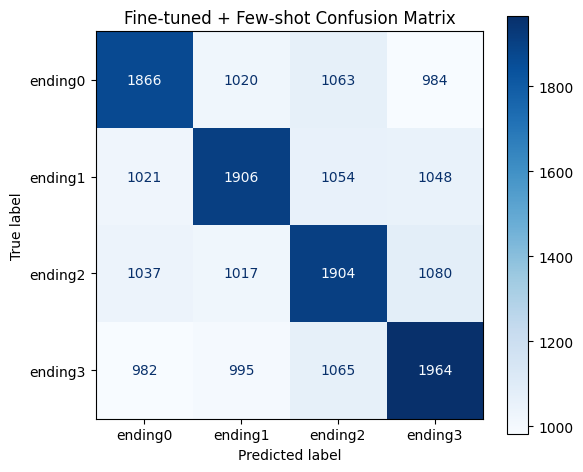

In [ ]:
logits = preds_finetuned_fewshot.predictions
labels = preds_finetuned_fewshot.label_ids
preds  = logits.argmax(axis=-1)
class_ids = [0, 1, 2, 3]
class_names = ["ending0", "ending1", "ending2", "ending3"]
cm = confusion_matrix(labels, preds, labels=class_ids)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, ax=ax, cmap="Blues")
ax.set_title("Fine-tuned + Few-shot Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
res_finetuned_cot = loaded_trainer.evaluate(encoded_val_cot)

In [ ]:
preds_finetuned_cot = loaded_trainer.predict(encoded_val_cot)

In [ ]:
post_acc = res_finetuned_cot["eval_accuracy"]
post_loss = res_finetuned_cot["eval_loss"]
post_ppl = math.exp(post_loss)
print("\n=== Fine-tune + Few-shots Metrics  ===")
print(f"Accuracy: {post_acc:.4f}")
print(f"Loss: {post_loss:.4f}")
print(f"Perplexity:  {post_ppl:.4f}")


=== Fine-tune + Few-shots Metrics  ===
Accuracy: 0.6918
Loss: 0.7877
Perplexity:  2.1982


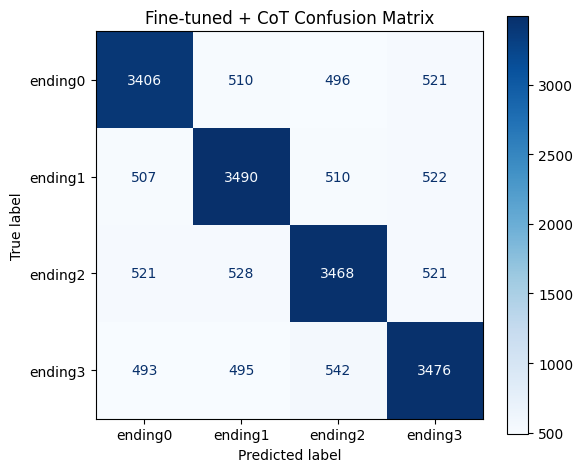

In [ ]:
logits = preds_finetuned_cot.predictions
labels = preds_finetuned_cot.label_ids
preds  = logits.argmax(axis=-1)
class_ids = [0, 1, 2, 3]
class_names = ["ending0", "ending1", "ending2", "ending3"]
cm = confusion_matrix(labels, preds, labels=class_ids)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, ax=ax, cmap="Blues")
ax.set_title("Fine-tuned + CoT Confusion Matrix")
plt.tight_layout()
plt.show()

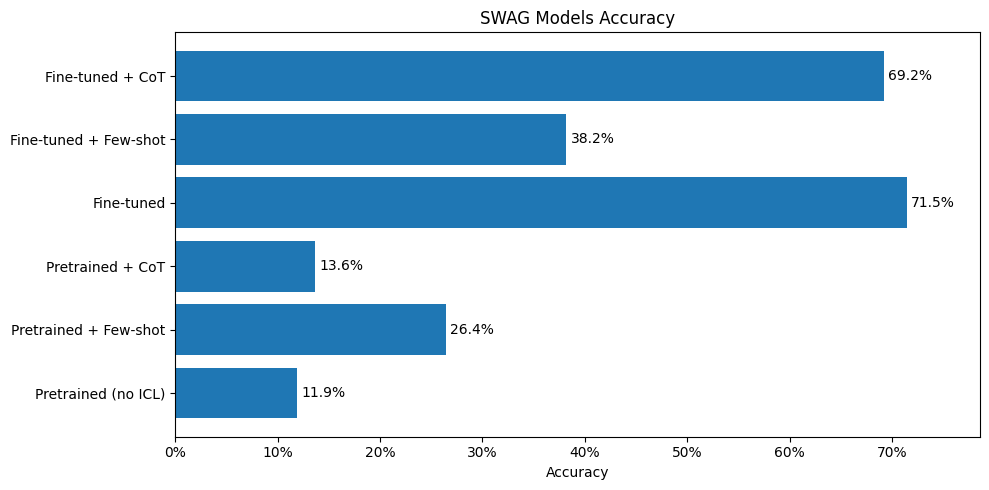

In [162]:
labels = [
    "Pretrained (no ICL)",
    "Pretrained + Few-shot",
    "Pretrained + CoT",
    "Fine-tuned",
    "Fine-tuned + Few-shot",
    "Fine-tuned + CoT",
]
values = [
    res_baseline["eval_accuracy"],
    res_fewshot["eval_accuracy"],
    res_cot["eval_accuracy"],
    post_metrics["eval_accuracy"],
    res_finetuned_fewshot["eval_accuracy"],
    res_finetuned_cot["eval_accuracy"],
]

y = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(y, values)

ax.set_title("SWAG Models Accuracy")
ax.set_xlabel("Accuracy")
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_yticks(y, labels)

for bar, v in zip(bars, values):
    ax.annotate(f"{v*100:.1f}%",
                xy=(v, bar.get_y() + bar.get_height()/2),
                xytext=(3, 0),
                textcoords="offset points",
                va="center", ha="left")

ax.set_xlim(0, min(1.0, max(values)*1.10))
plt.tight_layout()
plt.show()

### Analyse the results

The best performance is for fine-tuned model without ICL. As we can see, ICL's performance became worse which when apply to fine-tuned moddel and it is natural because our model wasn't trained on those datasets. We should fine-tune the model with few shot style to show that the performance will be better in this way than simply applying the few shot dataset on the model that isn't fine-tuned on the few-shots dataset.

### Questions

1. Fine-tuning a large model like BERT can be powerful but also resource-intensive. In
what scenarios might fine-tuning be the best approach? When might you prefer ICL
instead? Are there cases where you might combine both?

Answer:

**When fine-tuning is best**
- **Stable task & long-term use:** Same format for months; you’ll amortize training cost.
- **High accuracy/safety bar:** Need the strongest use of labels; weights adapt to your distribution.
- **Latency/throughput constraints:** No long prompt → faster/cheaper inference.
- **Privacy or short context:** Avoids exposing demos; keeps inputs compact.
- **You have labels + some compute:** Even adapter FT (LoRA) with modest data tends to beat prompting alone.

**When to prefer ICL**
- **Little/no labeled data:** You can curate a handful of good demos quickly.
- **Rapid iteration / many variants:** Tasks or policies change weekly; “program by prompt.”
- **Per-tenant personalization:** Different clients prefer different styles; swap demos at inference.
- **Can’t train on sensitive data:** You may *show* de-identified examples at inference but cannot train on them.

**When to combine fine-tuning + ICL**
- **Mild domain shift:** Fine-tuned on general data, need to nudge toward a subdomain (e.g., sports narratives).
- **Policy/format steering:** One fine-tuned model; control tone/caution/output schema via demos.
- **Seasonality/cold start:** Keep a strong base; rotate ICL snapshots to adapt quickly.

**Why a fine-tuned model may gain little from ICL**
- **Already internalized** task cues; demos add limited new signal.
- **Truncation risk:** ICL prefix consumes context budget.
- **Noisy demos / style mismatch:** Can distract a specialized head.

**Mitigations if combining**
- Keep demos **short & consistent** (context + options + “Answer: X”).
- **Increase `max_length`** for ICL runs to avoid truncation.
- **Retrieve** demos similar to the current query (embedding-based), not random.

**Real-world scenarios where FT + ICL shines**
- **Rapid domain tweaks** without retraining (product lines, news domains).
- **Per-tenant/policy controls** at inference time.
- **Evaluation-time steering** (e.g., more conservative picks in high-risk settings).

2. In your ICL prompts, you used examples from SWAG. If you had to design a custom
ICL prompt for a different task (e.g., predicting medical diagnoses or financial trends),
what kinds of examples would you choose? What factors would you consider when
selecting them?

Answer:

**What examples to include**
- **Representative & diverse:** Cover common cases **and** edge cases/near-misses.
- **High-quality labels:** Expert-verified/audited; avoid weak heuristics.
- **Balanced coverage:** Don’t overrepresent one label; include negatives/counterexamples.
- **Ambiguity & confounders:** Pairs that differ on the *decisive* feature.
- **Recent & local:** Reflect current guidelines/market regimes in the deployment region.
- **De-identified & compliant:** Remove PHI/PII; follow HIPAA/GDPR/internal policies.
- **No leakage:** Only include info available at prediction time.
- **Format-consistent & concise:** Same field order/units as your inference inputs; keep it short.

**Prompt templates**

*Medical*  
~~~text
Task: Pick the most likely diagnosis (A–D) from the context.

Example 1
Context:
- Age: 64, Sex: F
- Symptoms: exertional chest pain, dyspnea
- Vitals: BP 150/92, HR 96
- Labs: troponin normal, D-dimer low
Options:
A) Stable angina
B) Pulmonary embolism
C) Aortic dissection
D) Anxiety
Answer: A

Example 2
...
Answer: D

Now solve:
Context:
<patient summary here>
Options:
A) ...
B) ...
C) ...
D) ...
~~~

*Finance (risk/trend classification, multiple-choice)*  
~~~text
Task: Classify the next 7-day risk (A–D).

Example 1
Context:
- Sector: Semiconductors
- Recent returns: +3.2%, −1.1%, +0.5%
- Volatility: medium; RSI: 68
- Macro: CPI surprise +0.2%
Options:
A) Strong downside risk
B) Mild downside risk
C) Mild upside
D) Strong upside
Answer: C

Now solve:
Context:
<features for current asset>
Options:
A) ...
B) ...
C) ...
D) ...
~~~

**Practical knobs**
- **k shots:** 2–6 tends to work better than 10+ (signal vs. length).
- **Ordering:** Put the most informative demo first; keep order fixed for evals.
- **Short rationales (optional):** If included, keep to one sentence and consistent phrasing; watch for truncation.
- **Metrics to monitor:** Overall accuracy, **per-class accuracy**, log-loss (confidence), and confusion matrices to spot label-specific shifts.